<a href="https://colab.research.google.com/github/steve-mir/fcc_ml_cert/blob/main/Copy_of_fcc_cat_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.864.jpg  
  inflating: cats_and_dogs/train/dogs/dog.870.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.870.jpg  
  inflating: cats_and_dogs/train/dogs/dog.871.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.871.jpg  
  inflating: cats_and_dogs/train/dogs/dog.865.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.865.jpg  
  inflating: cats_and_dogs/train/dogs/dog.695.jpg  
  inflating: __MACOSX/cats_and

In [3]:
# 3
print('Train:', total_train)
print('Validation:', total_val)
print('Test:', total_test)
train_image_generator = ImageDataGenerator(rescale = 1./255)
validation_image_generator = ImageDataGenerator(rescale = 1./255)
test_image_generator = ImageDataGenerator(rescale = 1./255)

train_data_gen = train_image_generator.flow_from_directory(
                  train_dir,
                  target_size =(150, 150),  # target_size = input image size
                  batch_size = 20,
                  class_mode ='binary')
val_data_gen = validation_image_generator.flow_from_directory(
                  validation_dir,
                  target_size =(150, 150),  # target_size = input image size
                  batch_size = 20,
                  class_mode ='binary')
test_data_gen = test_image_generator.flow_from_directory(
                    PATH,
                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                    batch_size=batch_size,
                    classes=['test'],
                    shuffle=False)

# train_data_gen = train_image_generator.flow_from_directory(
#                   train_dir,
#                   target_size=(IMG_HEIGHT, IMG_WIDTH),
#                   class_mode='binary',
#                   batch_size=batch_size)

# val_data_gen = validation_image_generator.flow_from_directory(
#                 validation_dir,
#                 target_size=(IMG_HEIGHT, IMG_WIDTH),
#                 class_mode='binary',
#                 batch_size=batch_size)

# test_data_gen = test_image_generator.flow_from_directory(
#                   test_dir,
#                   target_size=(IMG_HEIGHT, IMG_WIDTH),
#                   class_mode='binary',
#                   batch_size=batch_size,
#                   shuffle=False)

Train: 2001
Validation: 1001
Test: 51
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


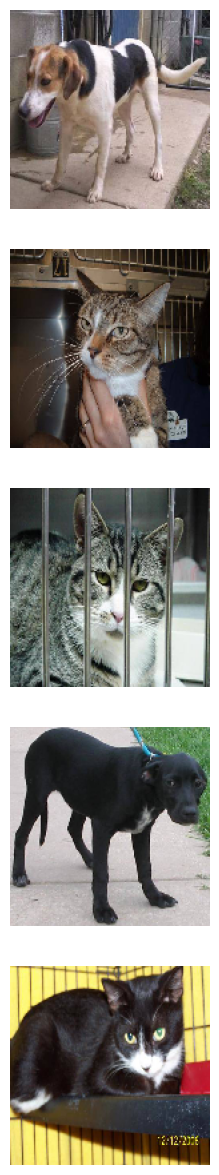

In [4]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [5]:
# 5
train_image_generator = ImageDataGenerator(
                            rescale=1./255,
                            horizontal_flip=True,
                            rotation_range=20,
                            zoom_range=0.15,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.15,
                            fill_mode="nearest")
# train_image_generator = ImageDataGenerator(rescale=1./255, rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, brightness_range=(0.7, 1.3), shear_range=10.0, zoom_range=0.2, horizontal_flip=True)



Found 2000 images belonging to 2 classes.


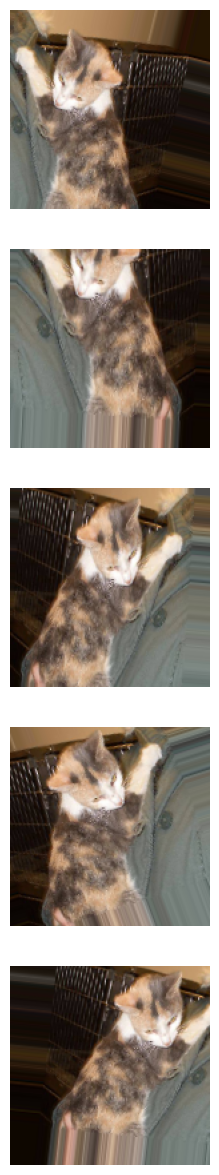

In [6]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [7]:
# 7
model = Sequential()
# Convolutions
model.add(Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(Conv2D(32, (3,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Dense layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Optimizer
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


model.summary()

# model = Sequential([
#   Conv2D(16, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
#   MaxPooling2D(2, 2),
#   Conv2D(32, (3, 3), activation='relu'),
#   MaxPooling2D(2, 2),
#   Conv2D(64, (3, 3), activation='relu'),
#   MaxPooling2D(2, 2),
#   Conv2D(64, (3, 3), activation='relu'),
#   MaxPooling2D(2,2),
#   Flatten(),
#   Dropout(0.5),
#   Dense(512, activation='relu'),
#   Dense(1, activation='sigmoid')
# ])

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [8]:
train_steps = int(ceil(1. * total_train / batch_size))
val_steps   = int(ceil(1. * total_val / batch_size))

print(train_steps, val_steps)

16 8


In [9]:
# 8
history = model.fit(
    train_data_gen, steps_per_epoch=train_steps,
    validation_data=val_data_gen, validation_steps=val_steps,
    epochs=epochs
)
# history = model.fit(x=train_data_gen, steps_per_epoch=8, epochs=epochs, validation_data=val_data_gen, validation_steps=8, verbose=1)

Epoch 1/15
16/16 [==============================] - 30s 1s/step - loss: 2.0927 - accuracy: 0.4825 - val_loss: 0.9763 - val_accuracy: 0.4563
Epoch 2/15
16/16 [==============================] - 16s 1s/step - loss: 0.7581 - accuracy: 0.5075 - val_loss: 0.6792 - val_accuracy: 0.5437
Epoch 3/15
16/16 [==============================] - 17s 1s/step - loss: 0.6896 - accuracy: 0.5485 - val_loss: 0.6290 - val_accuracy: 0.6438
Epoch 4/15
16/16 [==============================] - 16s 1s/step - loss: 0.6593 - accuracy: 0.5805 - val_loss: 0.6325 - val_accuracy: 0.6062
Epoch 5/15
16/16 [==============================] - 16s 1s/step - loss: 0.6594 - accuracy: 0.5765 - val_loss: 0.6083 - val_accuracy: 0.6687
Epoch 6/15
16/16 [==============================] - 18s 1s/step - loss: 0.6553 - accuracy: 0.6030 - val_loss: 0.6198 - val_accuracy: 0.6062
Epoch 7/15
16/16 [==============================] - 16s 1s/step - loss: 0.6598 - accuracy: 0.5925 - val_loss: 0.6184 - val_accuracy: 0.6500
Epoch 8/15
16/16 [==

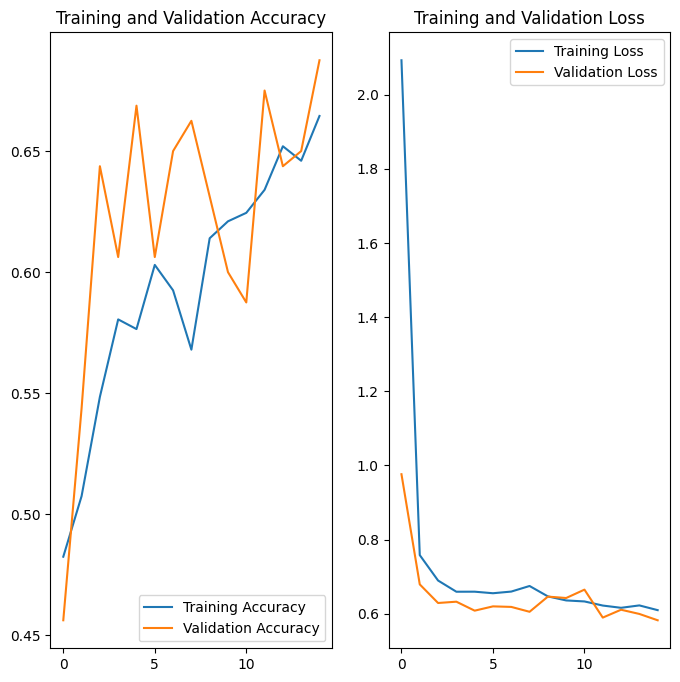

In [10]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [11]:
probabilities = model.predict(test_data_gen).flatten()
probabilities

1/1 [==============================] - 1s 652ms/step


array([0.51723987, 0.24952479, 0.36185822, 0.9341096 , 0.5194453 ,
       0.523265  , 0.7219439 , 0.307518  , 0.47704014, 0.8892988 ,
       0.7053193 , 0.6578095 , 0.47503388, 0.1953677 , 0.5744509 ,
       0.6573801 , 0.645852  , 0.71244353, 0.7019573 , 0.6422932 ,
       0.35883445, 0.8159439 , 0.35288212, 0.77610976, 0.73466504,
       0.5495951 , 0.9951735 , 0.3464657 , 0.46397507, 0.509931  ,
       0.6446674 , 0.46031523, 0.7460699 , 0.9999982 , 0.4527106 ,
       0.56931096, 0.99917597, 0.79899466, 0.5423243 , 0.47715667,
       0.40613925, 0.5355975 , 0.88516223, 0.6132216 , 0.63823193,
       0.49965036, 0.41060567, 0.66050565, 0.21116962, 0.62009907],
      dtype=float32)

In [12]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 66.0% of the images of cats and dogs.
You passed the challenge!
